# **Age prediction with BERT on PAN**

---



### Installing and importing dependencies

In [3]:
!pip install transformers==3
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
import pandas as pd
from transformers import BertForSequenceClassification

### Loading data

In [4]:
# Loading files from drive
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Language, speech and dialogue processing/Datasets/df_pan_train.csv') 
df = df.drop(['Unnamed: 0', 'lang', 'id', 'gender'], axis=1)
df = df.sample(100000)

Mounted at /content/drive


In [5]:
ages = df["age_group"].unique().tolist()
ages.sort()
age_dict = {}
for age in ages:
  age_dict[age] = df.loc[df['age_group'] == age]

for key, value in age_dict.items():
  age_dict[key] = value
  
print(age_dict)

{'10s':        age_group                                               text
351989       10s  the entire procedure ought to be reversed engi...
361153       10s  Very similar to the stock market, forex tradin...
23098        10s  <b>;Related topics:</b>; <a href="http://en.pa...
107661       10s  I did exercises not only during the PE class, ...
123428       10s  This is substantially mature occasion and prin...
...          ...                                                ...
272664       10s  Namee:\n<br />;Agee:\n<br />;Sexx:\n<br />;Are...
374819       10s  110). At least a 500 years of serious and vari...
302954       10s  The spiders belong to the biggest phylum of th...
236181       10s  Circle lenses are great for transforming your ...
340642       10s  If you are looking for a fast, portable scanne...

[6952 rows x 2 columns], '20s':        age_group                                               text
369170       20s  Grab the attention of your loved ones and let ...
290049 

In [6]:
dataframes_10s = []
dataframes_20s = []
dataframes_30s = []
for key, value in age_dict.items():
  if key == '10s':
    dataframes_10s.append(value)
  elif key == '20s':
    dataframes_20s.append(value)
  elif '30s':
    dataframes_30s.append(value)

df_10s = pd.concat(dataframes_10s)
df_20s = pd.concat(dataframes_20s)
df_30s = pd.concat(dataframes_30s)

all_dataframes = [df_10s, df_20s, df_30s]

min_len = len(all_dataframes[0])

for df in all_dataframes:
  if len(df) < min_len:
    min_len = len(df)

df_10s["age"] = 0
df_20s["age"] = 1
df_30s["age"] = 2

all_dataframes = [df_10s.sample(min_len), df_20s.sample(min_len), df_30s.sample(min_len)]


df = pd.concat(all_dataframes)

In [7]:
df.head()

,age_group,text,age
127971,10s,Thousands and thousands of most people in thes...,0
102314,10s,Get Your Website on Google's Page 1 with Autom...,0
334560,10s,The actual Samsung Galaxy Nexus uses about fro...,0
169273,10s,Do you need fresh workwear to perform your job...,0
264795,10s,Many individuals worldwide are affected everyd...,0


In [8]:
df['age'].value_counts()

2    6952
1    6952
0    6952
Name: age, dtype: int64

In [9]:
possible_labels = df.age.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{0: 0, 1: 1, 2: 2}

In [10]:
df['label'] = df.age.replace(label_dict)

In [11]:
df.head()

,age_group,text,age,label
127971,10s,Thousands and thousands of most people in thes...,0,0
102314,10s,Get Your Website on Google's Page 1 with Autom...,0,0
334560,10s,The actual Samsung Galaxy Nexus uses about fro...,0,0
169273,10s,Do you need fresh workwear to perform your job...,0,0
264795,10s,Many individuals worldwide are affected everyd...,0,0


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

In [13]:
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [14]:
df.groupby(['age', 'label', 'data_type']).count()

age_group  text
age label data_type                 
0   0     train           5909  5909
          val             1043  1043
1   1     train           5909  5909
          val             1043  1043
2   2     train           5909  5909
          val             1043  1043

In [15]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

In [16]:
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.


In [17]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [18]:
len(dataset_train), len(dataset_val)

(17727, 3129)

In [19]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [20]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [21]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

In [22]:
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [23]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    total = 0
    correct = 0
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])/ len(y_true)}\n')

        correct += len(y_preds[y_preds==label])
        total += len(y_true)

    print(f'Overall Accuracy: {correct/total}\n')
    return preds_flat, labels_flat
    

In [24]:
import random
import numpy as np

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [26]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [27]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'/content/drive/MyDrive/Language, speech and dialogue processing/Bert_models/BERT_age_PAN_full_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')


Epoch 1
Training loss: 1.0679779527634812
Validation loss: 1.0387229829712317
F1 Score (Weighted): 0.3953129204796575



Epoch 2
Training loss: 1.011557599779595
Validation loss: 1.0837675425673148
F1 Score (Weighted): 0.4153018297251569



Epoch 3
Training loss: 0.8834242852514096
Validation loss: 1.2263713530188896
F1 Score (Weighted): 0.44231945190754174



Epoch 4
Training loss: 0.7131368467969769
Validation loss: 1.6516820190015427
F1 Score (Weighted): 0.4429552035295413



Epoch 5
Training loss: 0.5916641036992503
Validation loss: 2.1240759602402295
F1 Score (Weighted): 0.4429025040515475



In [28]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [29]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Language, speech and dialogue processing/Bert_models/BERT_age_PAN_full_epoch_5.model', map_location=torch.device('cpu')))

<All keys matched successfully>

In [30]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [31]:
predictions, true_vals = accuracy_per_class(predictions, true_vals)



Class: 0
Accuracy: 0.46116970278044106

Class: 1
Accuracy: 0.439117929050815

Class: 2
Accuracy: 0.42569511025886864

Overall Accuracy: 0.4419942473633749



**Confusion Matrix**

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# confusion matrix plot function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Language, speech and dialogue processing/AGE_PAN_BERT_confusion_matrix.png')

Normalized confusion matrix
[[0.46 0.19 0.35]
 [0.26 0.44 0.3 ]
 [0.33 0.25 0.43]]


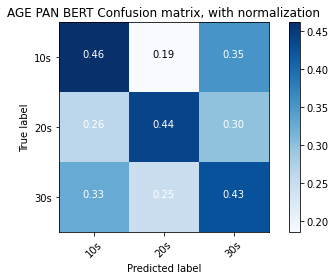

In [33]:

conf_matrix = confusion_matrix(np.array(true_vals), np.array(predictions), labels=[0, 1, 2])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix(conf_matrix, classes=['10s', '20s', '30s'], normalize=True, title='AGE PAN BERT Confusion matrix, with normalization')